In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage

torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

In [4]:
PATH = Path('/fastai/data/ILSVRC/Data/CLS-LOC/')
PATH_TRN = PATH/'train'

In [5]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:07<00:00, 72605780.16it/s]


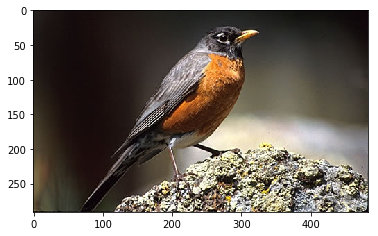

In [9]:
img_fn = PATH_TRN/'n01558993'/'n01558993_9684.JPEG'
img = open_image(str(img_fn))
plt.imshow(img)

In [10]:
sz=288

In [11]:
trn_tfms, val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

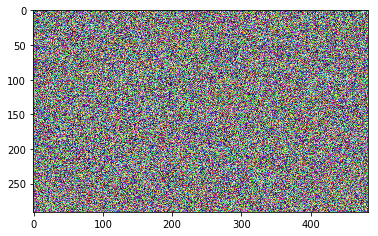

In [12]:
opt_img =  np.random.uniform(0,1, size=img.shape).astype(np.float32)
plt.imshow(opt_img)

above image is too grainy and if we train with this it may not train well, so we need to smooth out the image to represent hoe regular images look

In [13]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

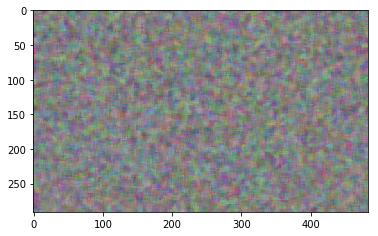

In [14]:
plt.imshow(opt_img)

In [15]:
opt_img = val_tfms(opt_img)/2 #?
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [16]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [17]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [21]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [22]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000 # sine loss were too low it was not training well, so *1000

In [23]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter += 1
    if n_iter%show_iter == 0: print(f'Iteration: n_iter, loss: {loss.data[0]}')
    return loss

In [24]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

Iteration: n_iter, loss: 0.7843771576881409
Iteration: n_iter, loss: 0.33363762497901917
Iteration: n_iter, loss: 0.21492233872413635
Iteration: n_iter, loss: 0.16120044887065887
Iteration: n_iter, loss: 0.13212445378303528
Iteration: n_iter, loss: 0.11196540296077728
Iteration: n_iter, loss: 0.09847230464220047
Iteration: n_iter, loss: 0.08893223851919174
Iteration: n_iter, loss: 0.08191398531198502
Iteration: n_iter, loss: 0.07669102400541306


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


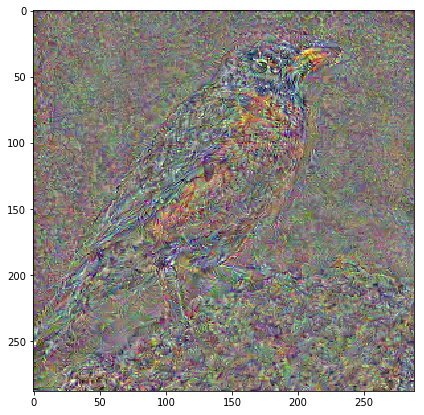

In [25]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x)

## forward hook

In [84]:
class SaveFeatures():
    features = None
    def __init__(self,m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [85]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [86]:
#get layer before maxPool which has all the featurea activations, best place before it gets maxpool
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [87]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [88]:
def get_opt():
    opt_img = np.random.uniform(0,1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [89]:
opt_img_v, optimizer =  get_opt()

In [90]:
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [91]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

every time m_vgg() is passed an input sf.features has the values from activations of layer 32

In [92]:
def actn_loss2(x):
    m_vgg(x)
    out = to_gpu(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [93]:
n_iter=0
while n_iter <= max_iter : optimizer.step(partial(step,actn_loss2))

Iteration: n_iter, loss: 0.21467484533786774
Iteration: n_iter, loss: 0.0924149602651596
Iteration: n_iter, loss: 0.06118245795369148
Iteration: n_iter, loss: 0.046506963670253754
Iteration: n_iter, loss: 0.03788284212350845
Iteration: n_iter, loss: 0.03230765834450722
Iteration: n_iter, loss: 0.02825039066374302
Iteration: n_iter, loss: 0.02528725378215313
Iteration: n_iter, loss: 0.02298240177333355
Iteration: n_iter, loss: 0.021139629185199738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


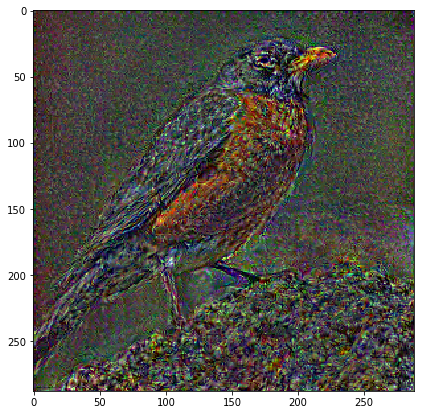

In [94]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data), 1, 4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x)

In [95]:
sf.close()

## Style match

In [101]:
style_fn = '/fastai/data/style/starry_night.jpg'

In [102]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((1014, 1280, 3), (291, 483, 3))

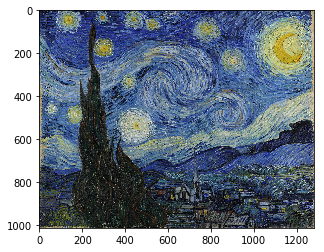

In [103]:
plt.imshow(style_img)

In [107]:
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); 
    print(rat)
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [108]:
style = scale_match(img,style_img)

0.37734375


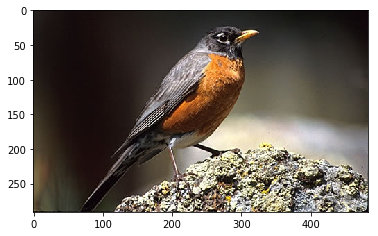

In [123]:
plt.imshow(img)

((291, 483, 3), (291, 483, 3))

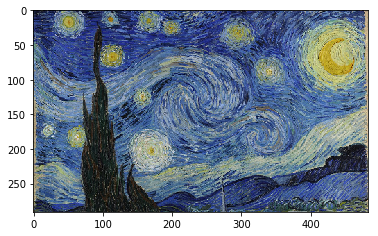

In [109]:
plt.imshow(style)
style.shape, img.shape

In [110]:
opt_img_v, optimizer = get_opt()

In [111]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [112]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [113]:
style_tfm = val_tfms(style_img)

In [114]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

By flattening a channel and gram matrix( multiply flattened matrix by itself), we obtain same features reinforced along the diagonal `c1*c1 c2*c2 etc` and similar features reinforces along other positions. This way we collect style concentrations across channels like brush stroke etc. 

we divide the mm(matrix multiple) of x and x transpose by the input elements to normalize and also add a factor of 1e6 as the numbers are very low to scale them

In [116]:
def gram(input):
    b,c,h,w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [119]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [to_gpu(o.features) for o in sfs]
    losses =  [gram_mse_loss(o,s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [120]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: n_iter, loss: 264.1415100097656
Iteration: n_iter, loss: 119.30033874511719
Iteration: n_iter, loss: 68.58077239990234
Iteration: n_iter, loss: 44.132972717285156
Iteration: n_iter, loss: 28.967899322509766
Iteration: n_iter, loss: 19.697677612304688
Iteration: n_iter, loss: 14.125046730041504
Iteration: n_iter, loss: 10.839984893798828
Iteration: n_iter, loss: 8.779441833496094
Iteration: n_iter, loss: 7.4656805992126465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


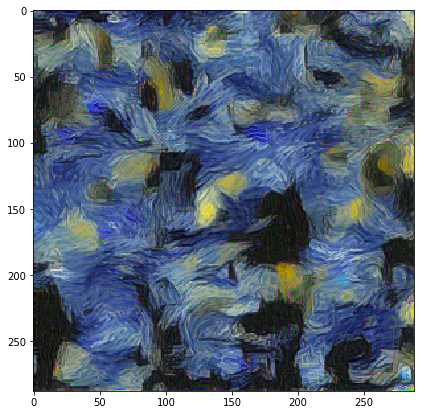

In [122]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x)

In [124]:
for sf in sfs: sf.close()

## Style transfer

In [127]:
opt_img_v, optimizer = get_opt()

In [128]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [129]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [to_gpu(o.features) for o in sfs]
    losses = [gram_mse_loss(o,s) for o,s in zip(outs, targ_styles)]
    cnt_loss = F.mse_loss(outs[3], targ_vs[3])*1e6
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [133]:
n_iter = 0
while n_iter <= max_iter : optimizer.step(partial(step, comb_loss))

Iteration: n_iter, loss: 657.5933227539062
Iteration: n_iter, loss: 642.7908935546875
Iteration: n_iter, loss: 630.2258911132812
Iteration: n_iter, loss: 619.79736328125
Iteration: n_iter, loss: 611.188232421875
Iteration: n_iter, loss: 603.739990234375
Iteration: n_iter, loss: 597.1296997070312
Iteration: n_iter, loss: 591.385498046875
Iteration: n_iter, loss: 586.2928466796875
Iteration: n_iter, loss: 581.47509765625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 287.5, 287.5, -0.5)

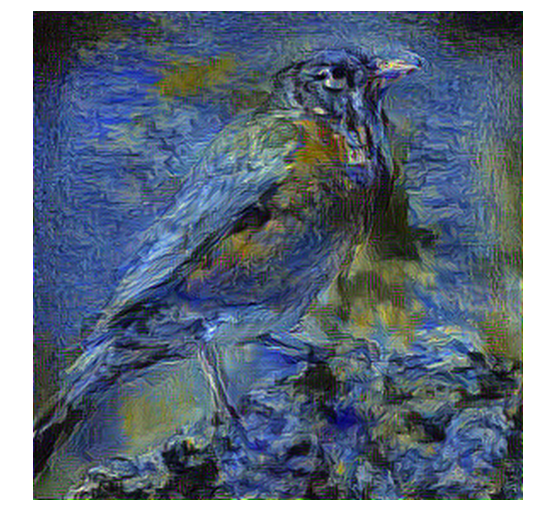

In [134]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data), 1, 4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off')

In [135]:
for sf in sfs: sf.close()